<a href="https://colab.research.google.com/github/ucfilho/marquesgabi_abril_2020/blob/master/Cat_vs_Dog_abril_06_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import os 
import cv2
import re, random
from tqdm import tqdm_notebook
from random import shuffle
import shutil


%matplotlib inline

In [0]:
#https://www.kaggle.com/sarvajna/dogs-vs-cats-keras-solution
#https://www.kaggle.com/deadskull7/cats-vs-dogs-84

In [0]:
!pip install keras-tqdm
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras_tqdm import TQDMNotebookCallback
#from keras.models import Sequential
from tensorflow.python.keras import Sequential
#from keras.layers import Dense
from tensorflow.python.keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
#from keras import layers, models, optimizers
#from keras import backend as K

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import itertools

import matplotlib.image as mpimg
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
data_directory = '/tmp'
model_directory = '/afs/dogscats/run1'

if not os.path.isdir(model_directory):
    os.makedirs(model_directory)

In [0]:
def get_data(local_data_root: str, is_chief: bool=True):
    data_dir = os.path.join(local_data_root, 'datasets/dogscats')
    
    if is_chief:
        if not os.path.isdir(data_dir):
            # Download the data zip to our data directory and extract
            fallback_url = 'http://files.fast.ai/data/dogscats.zip'
            tf.keras.utils.get_file(
                os.path.join('/tmp', os.path.basename(fallback_url)), 
                fallback_url, 
                cache_dir='/tmp',
                extract=True)
        
    return data_dir

In [0]:
data_dir = get_data(data_directory, True)

In [0]:
def organize_datasets(path_to_data, n=4000, ratio=0.2):
    files = os.listdir(path_to_data)
    files = [os.path.join(path_to_data, f) for f in files]
    shuffle(files)
    files = files[:n]
    
    n = int(len(files) * ratio)
    val, train = files[:n], files[n:]
    

    shutil.rmtree('./data/')
    print('/data/ removed')

    for c in ['dogs', 'cats']: 
        os.makedirs('./data/train/{0}/'.format(c))
        os.makedirs('./data/validation/{0}/'.format(c))

    print('folders created !')

    for t in tqdm_notebook(train):
        if 'cat' in t:
            shutil.copy2(t, os.path.join('.', 'data', 'train', 'cats'))
        else:
            shutil.copy2(t, os.path.join('.', 'data', 'train', 'dogs'))
     
    for v in tqdm_notebook(val):
        if 'cat' in v:
            shutil.copy2(v, os.path.join('.', 'data', 'validation', 'cats'))
        else:
            shutil.copy2(v, os.path.join('.', 'data', 'validation', 'dogs'))
            
    print('Data copied!')

In [0]:
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1/255.,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True
                                    )
val_datagen = ImageDataGenerator(rescale=1/255.)

In [0]:
os.listdir(data_dir)

['valid', 'test1', 'models', 'sample', 'train']

In [0]:
os.listdir(os.path.join(data_dir, 'valid'))

['cats', 'dogs']

In [0]:
cats = os.listdir(os.path.join(data_dir, 'valid', 'cats'))
cats[0:3]

['cat.11341.jpg', 'cat.8233.jpg', 'cat.2703.jpg']

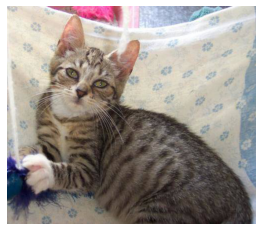

In [0]:
img = plt.imread(os.path.join(data_dir, 'valid', 'cats', cats[0]))
plt.axis("off")
plt.imshow(img)

In [0]:
img.shape

(437, 499, 3)

In [0]:
dogs = os.listdir(os.path.join(data_dir, 'valid', 'dogs'))
dogs[0:3]

['dog.1220.jpg', 'dog.7312.jpg', 'dog.5692.jpg']

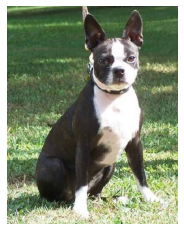

In [0]:
img = plt.imread(os.path.join(data_dir, 'valid', 'dogs', dogs[0]))
plt.axis("off")
plt.imshow(img)

In [0]:
print(len(dogs))

1000


In [0]:
x = [] # images as arrays
y = [] # labels
img_width = 50
img_height = 50
k=-1

for i in range(2000):
  
  if(i%2==0):
    k=k+1
    path = os.path.join(data_dir, 'valid', 'dogs', dogs[k])
    #img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(path) 
    img = cv2.resize(img, (img_width,img_height), interpolation=cv2.INTER_CUBIC)    
    #x.append([np.array(img)])
    x.append(img)
    y.append(1)

  else:
    path = os.path.join(data_dir, 'valid', 'cats', cats[k])
    #img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    img = cv2.imread(path) 
    img = cv2.resize(img, (img_width,img_height), interpolation=cv2.INTER_CUBIC)
    #x.append([np.array(img)])
    x.append(img)
    y.append(0)

    
#print(len(y))
#print(y)  
#print(x)  
    

In [0]:
# First split the data in two sets, 80% for training, 20% for Val/Test)
X_train, X_val, Y_train, Y_val = train_test_split(x,y, test_size=0.05, random_state=1)

In [0]:
print(X_train)

[array([[[169, 205, 215],
        [171, 203, 214],
        [172, 202, 213],
        ...,
        [161, 186, 199],
        [166, 191, 204],
        [148, 179, 186]],

       [[161, 199, 208],
        [169, 201, 212],
        [176, 206, 217],
        ...,
        [142, 173, 184],
        [154, 186, 196],
        [165, 192, 199]],

       [[164, 205, 217],
        [168, 203, 216],
        [154, 195, 204],
        ...,
        [169, 198, 205],
        [161, 190, 197],
        [154, 183, 190]],

       ...,

       [[215, 229, 228],
        [197, 210, 209],
        [201, 209, 213],
        ...,
        [171, 190, 193],
        [204, 210, 215],
        [233, 244, 248]],

       [[166, 187, 193],
        [168, 188, 195],
        [162, 182, 189],
        ...,
        [150, 166, 169],
        [206, 217, 221],
        [221, 234, 240]],

       [[204, 211, 215],
        [206, 213, 216],
        [208, 214, 212],
        ...,
        [176, 192, 194],
        [218, 229, 233],
        [231, 240, 241]

In [0]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 22, 22, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 64)          1

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [0]:
train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size)

In [0]:
nb_train_samples = len(X_train)
nb_validation_samples = len(X_val)
batch_size = 16

In [0]:
print(len(Y_val))
print(len(X_train))

100
1900


In [0]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [0]:
train_generator = train_datagen.flow(np.array(X_train), Y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(np.array(X_val), Y_val, batch_size=batch_size)

In [0]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
118/118 [==============================] - 7s 61ms/step - loss: 0.6957 - accuracy: 0.4958 - val_loss: 0.6902 - val_accuracy: 0.5417
Epoch 2/30
118/118 [==============================] - 7s 59ms/step - loss: 0.6900 - accuracy: 0.5504 - val_loss: 0.6711 - val_accuracy: 0.5729
Epoch 3/30
118/118 [==============================] - 7s 58ms/step - loss: 0.6768 - accuracy: 0.5993 - val_loss: 0.7156 - val_accuracy: 0.5104
Epoch 4/30
118/118 [==============================] - 7s 58ms/step - loss: 0.6504 - accuracy: 0.6178 - val_loss: 0.6491 - val_accuracy: 0.6458
Epoch 5/30
118/118 [==============================] - 7s 59ms/step - loss: 0.6350 - accuracy: 0.6423 - val_loss: 0.6211 - val_accuracy: 0.6250
Epoch 6/30
118/118 [==============================] - 7s 59ms/step - loss: 0.6169 - accuracy: 0.6497 - val_loss: 0.6242 - val_accuracy: 0.6667
Epoch 7/30
118/118 [==============================] - 7s 59ms/step